# Graph Learning
## Lab 6: Spectral Embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [5]:
dataset = karate_club(metadata=True)

In [6]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

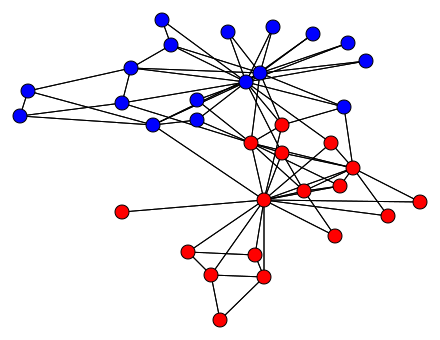

In [7]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first component of the embedding to the ground-truth clusters.

In [8]:
spectral = Spectral(20, normalized=False)

In [9]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [10]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

In [11]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

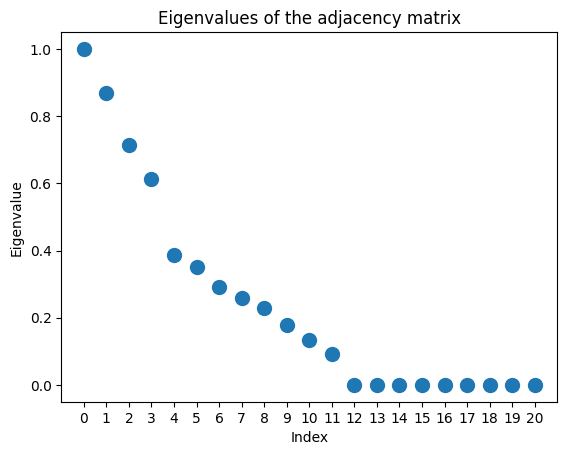

In [12]:
plt.scatter(np.arange(len(eigenvalues)), eigenvalues, marker='o', s=100)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the adjacency matrix')
plt.xticks(np.arange(0, len(eigenvalues), 1))
plt.show()

The spectrum suggests that the graph has a clear community structure, as indicated by a spectral gap after the first few eigenvalues. For the karate club graph, this means there are two well-separated clusters, which matches the known division of the club. The leading eigenvectors can be used to reveal and visualize these communities.

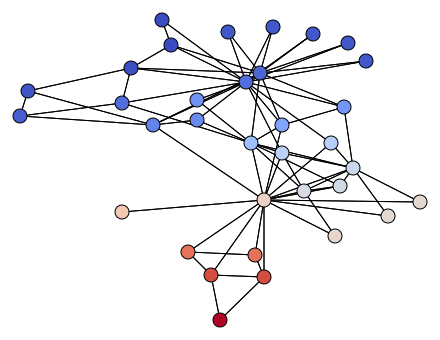

In [13]:
# display an eigenvector
image = visualize_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

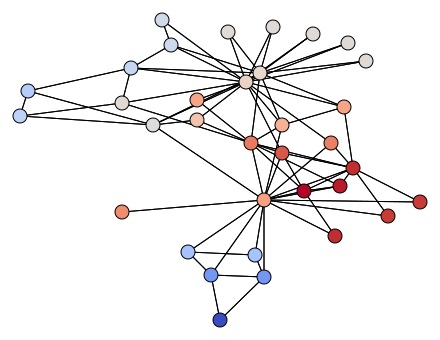

In [14]:
# display another eigenvector
image = visualize_graph(adjacency, position, scores=eigenvectors[:, 1])
SVG(image)

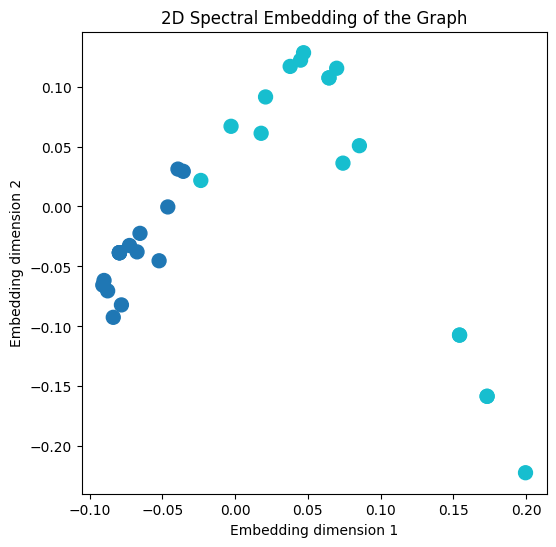

In [15]:
embedding = spectral.embedding_

embedding_2d = embedding[:, :2]

plt.figure(figsize=(6, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels_true, cmap='tab10', s=100)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('2D Spectral Embedding of the Graph')
plt.show()

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [16]:
dataset = openflights

In [17]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

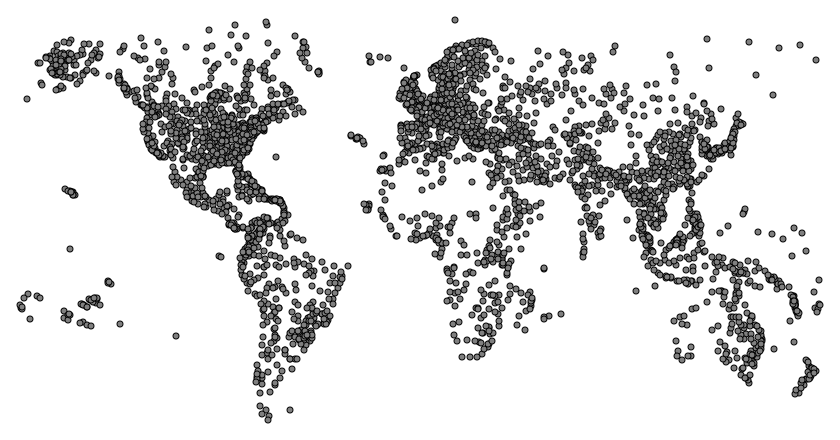

In [18]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space. You can use ``scikit-learn``for k-means.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. <br>**Hint:** Compute the Euclidean norm of the centroid of each cluster in the embedding space.

In [19]:
spectral = Spectral(20, normalized=True)

In [20]:
embedding = spectral.fit_transform(adjacency)

In [21]:
from sklearn.cluster import KMeans

# Apply k-means on the embedding (20 dimensions)
kmeans = KMeans(n_clusters=8, random_state=0)
clusters = kmeans.fit_predict(embedding)


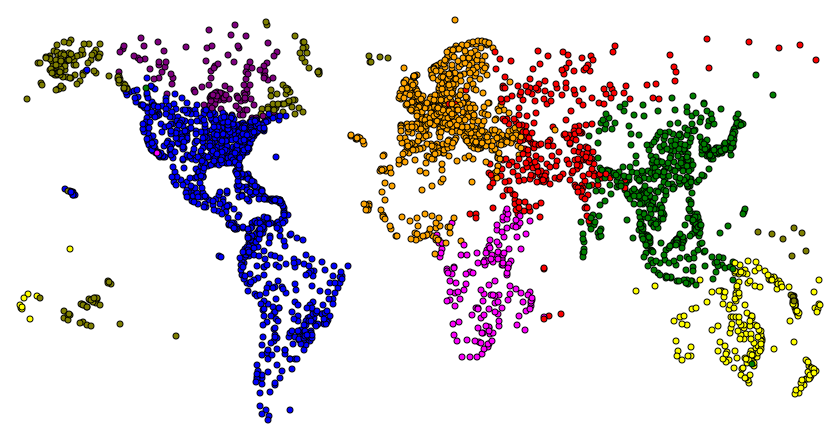

In [22]:
# Display the world map colored by cluster
image = visualize_graph(adjacency, position, labels=clusters, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

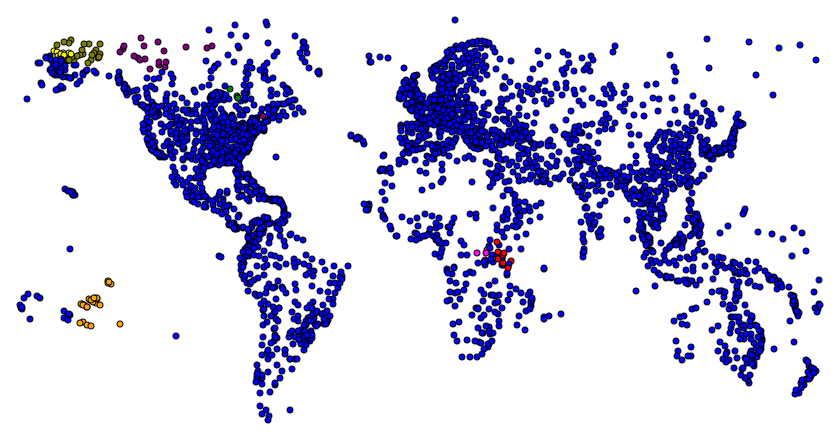

In [23]:
spectral = Spectral(20, normalized=False)
embedding = spectral.fit_transform(adjacency)

kmeans = KMeans(n_clusters=8, random_state=0)
clusters = kmeans.fit_predict(embedding)

# Display the world map colored by cluster
image = visualize_graph(adjacency, position, labels=clusters, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

With normalization, the embedding vectors are projected onto the unit sphere, so k-means clusters are mainly separated by direction (angular separation). This leads to clusters of similar size and cohesion, and the centroids have norms close to 1.
Without normalization, the embedding vectors can have very different magnitudes. Some clusters may be more dispersed or closer to the origin, resulting in centroids with smaller norms and less balanced clusters. Thus, normalization generally produces more interpretable and homogeneous clusters in the embedding space.

## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in the embedding space in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we project the vectors on the unit sphere.

In [24]:
spectral = Spectral(20, normalized=True)

## Wikipedia Vitals

In [25]:
dataset = wikivitals

In [26]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 20 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space. Compare with the top articles obtained with Personalized PageRank.
* Display the 3D-plot of each of the 11 labels in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the centroid of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot. Interpret the results.
* Display the dendrogram of the hierarchical clustering of the top-100 articles on **Arts** (in terms of Personalized PageRank). You might use the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space. Comment the results.

In [27]:
vangogh_index = np.where(names == 'Vincent van Gogh')[0][0]

In [28]:
# Compute cosine similarity between Vincent van Gogh and all articles in the embedding space
embedding = spectral.fit_transform(adjacency)
vangogh_embedding = embedding[vangogh_index]
cosine_similarities = embedding @ vangogh_embedding / (np.linalg.norm(embedding, axis=1) * np.linalg.norm(vangogh_embedding) + 1e-10)

# Get top 20 most similar articles (excluding itself if desired)
top20_sim_indices = np.argsort(cosine_similarities)[-20:][::-1]
top20_sim_articles = [str(names[i]) for i in top20_sim_indices]

print("Top 20 articles closest to 'Vincent van Gogh' in the embedding space (cosine similarity):")
for i, article in enumerate(top20_sim_articles, start=1):
    print(f"{i}. {article}")

Top 20 articles closest to 'Vincent van Gogh' in the embedding space (cosine similarity):
1. Vincent van Gogh
2. Georges Seurat
3. Paul Cézanne
4. Paul Gauguin
5. Henri de Toulouse-Lautrec
6. Franz Marc
7. Post-Impressionism
8. Edvard Munch
9. Henri Rousseau
10. Musée National d'Art Moderne
11. Performance art
12. Henri Matisse
13. Marcel Duchamp
14. Abstract art
15. Modern art
16. Impressionism
17. Antonin Artaud
18. Constantin Brâncuși
19. National Gallery of Art
20. Outsider art


In [29]:
pagerank = PageRank()
weights = {vangogh_index: 1.0}
scores = pagerank.fit_predict(adjacency, weights=weights)

top20_scores = np.argsort(scores)[-20:][::-1]
top20_articles = [str(names[i]) for i in top20_scores]
print("Top 20 articles closest to 'Vincent van Gogh' obtained by Personalized PageRank:")
for i, article in enumerate(top20_articles, start=1):
    print(f"{i}. {article}")

Top 20 articles closest to 'Vincent van Gogh' obtained by Personalized PageRank:
1. Vincent van Gogh
2. World War I
3. Metropolitan Museum of Art
4. Impressionism
5. Pablo Picasso
6. Modernism
7. Paul Cézanne
8. Cubism
9. National Gallery of Art
10. Post-Impressionism
11. Claude Monet
12. Paul Gauguin
13. Symbolism (arts)
14. Modern art
15. Museum of Modern Art
16. Art Nouveau
17. Expressionism
18. BBC
19. Wassily Kandinsky
20. Henri Matisse


In [30]:
import plotly.express as px

In [31]:
from scipy.cluster.hierarchy import linkage

In [32]:
# Compute centroids and sizes for each of the 11 labels
embedding_3d = embedding[:, :3]
centroids = []
sizes = []
for label in range(len(names_labels)):
    indices = np.where(labels == label)[0]
    if len(indices) > 0:
        centroid = embedding_3d[indices].mean(axis=0)
        centroids.append(centroid)
        sizes.append(len(indices))
    else:
        centroids.append(np.zeros(3))
        sizes.append(0)

centroids = np.array(centroids)

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    size=sizes,
    text=names_labels,
    color=names_labels,
    size_max=60,
    title="Centroids of 11 Wikipedia Vitals Labels in Spectral Embedding Space (Top 3 Dimensions)"
)
fig.update_traces(marker=dict(opacity=0.8))
fig.show()

In [41]:
from sknetwork.visualization import visualize_dendrogram

In [51]:
arts_index = np.where(names_labels == 'Arts')[0][0]
arts_articles = np.where(labels == arts_index)[0]

# Compute the Personalized PageRank scores for the 'Arts' label
pagerank = PageRank()
weights = {i: 1.0 for i in arts_articles}
scores = pagerank.fit_predict(adjacency, weights=weights)

Top 100 articles closest to 'Arts' obtained by Personalized PageRank:
1. Encyclopædia Britannica
2. Romanticism
3. Jazz
4. Modernism
5. Baroque
6. Classical music
7. Opera
8. Musical instrument
9. Orchestra
10. Metropolitan Museum of Art
11. Rock music
12. Folk music
13. Violin
14. Blues
15. Symbolism (arts)
16. British Museum
17. Oxford English Dictionary
18. Satire
19. Impressionism
20. Novel
21. Surrealism
22. Pop music
23. Art Nouveau
24. Romantic music
25. Modern art
26. Sculpture
27. Neoclassicism
28. Cubism
29. Music
30. Baroque music
31. Poetry
32. Painting
33. Art Deco
34. Trumpet
35. Bassoon
36. Academy Awards
37. Classicism
38. Double bass
39. Architecture
40. Country music
41. Hip hop music
42. Piano
43. Epic poetry
44. Electric guitar
45. Lute
46. Harmony
47. Harp
48. Museum of Modern Art
49. Cello
50. Oboe
51. Expressionism
52. Broadway theatre
53. Viola
54. Dada
55. Counterpoint
56. Science fiction
57. Flute
58. Electronic music
59. Guitar
60. Tragedy
61. Ancient Greek a

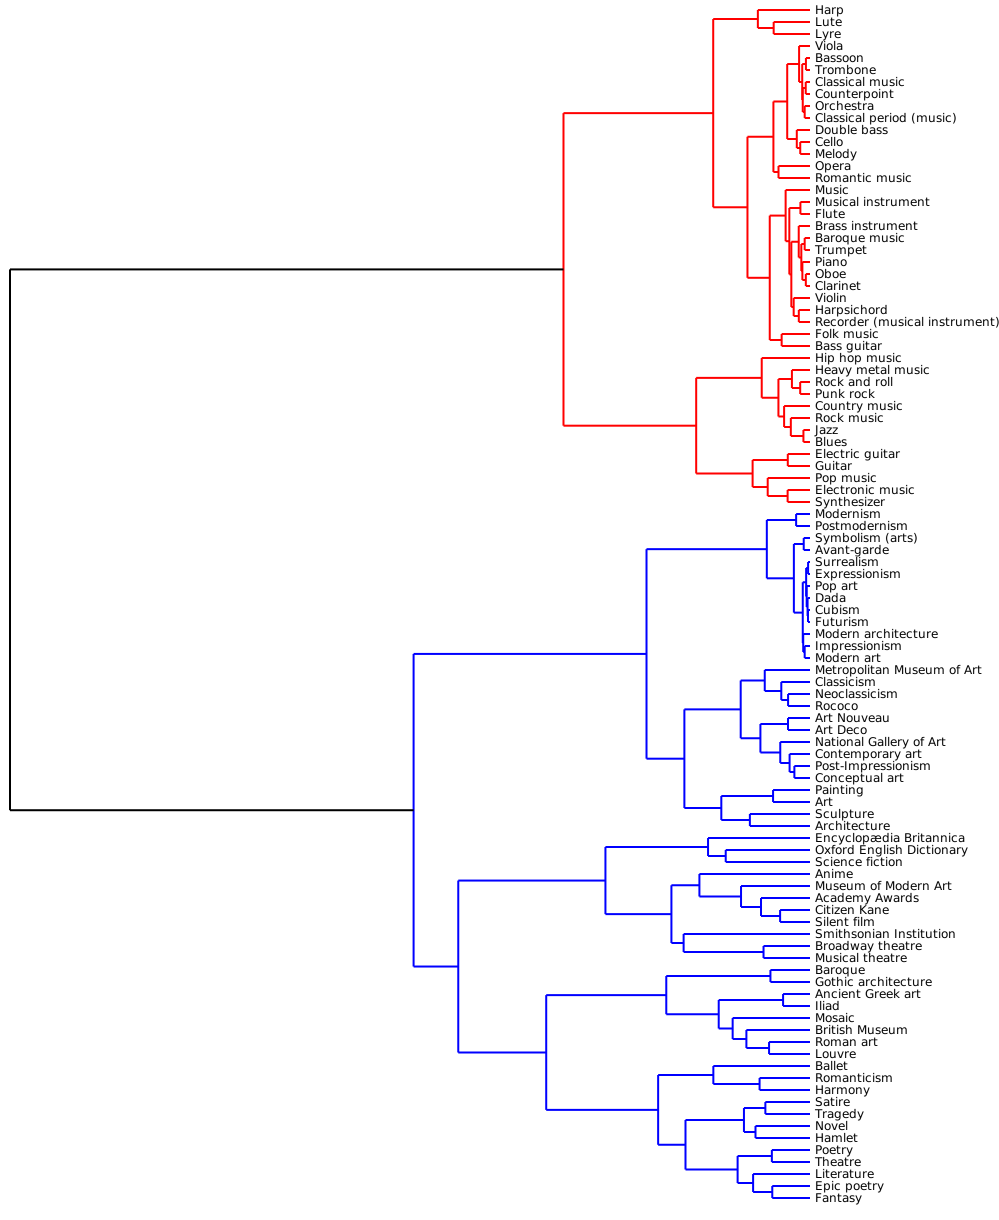

In [53]:
top_100_articles = arts_articles[np.argsort(scores[arts_articles])[-100:][::-1]]
print("Top 100 articles closest to 'Arts' obtained by Personalized PageRank:")
for i, article in enumerate(top_100_articles, start=1):
    print(f"{i}. {names[article]}")

dendrogram = linkage(embedding[top_100_articles], method='ward')

image = visualize_dendrogram(dendrogram, names=names[top_100_articles], width=800, height=1200, rotate=True)
SVG(image)

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

In [72]:
spectral = Spectral(20, normalized=True)
embedding_articles = spectral.fit_transform(biadjacency)
embedding_words = spectral.embedding_col_

In [73]:
# Find index of "Vincent van Gogh" among articles
vangogh_index = np.where(names == 'Vincent van Gogh')[0][0]
vangogh_embedding = embedding_articles[vangogh_index]
cosine_similarities = embedding_articles @ vangogh_embedding / (np.linalg.norm(embedding_articles, axis=1) * np.linalg.norm(vangogh_embedding) + 1e-10)

# Top 20 articles (among articles only)
top20_sim_indices = np.argsort(cosine_similarities[:10011])[-20:][::-1]
top20_sim_articles = [str(names[i]) for i in top20_sim_indices]

print("Top 20 articles closest to 'Vincent van Gogh' (bipartite embedding) with cosine similarity:")
for i, article in enumerate(top20_sim_articles, 1):
    print(f"{i}. {article}")

Top 20 articles closest to 'Vincent van Gogh' (bipartite embedding) with cosine similarity:
1. Vincent van Gogh
2. Edvard Munch
3. Arthur Rimbaud
4. Henri Rousseau
5. Claude Monet
6. Victor Hugo
7. Henri de Toulouse-Lautrec
8. Camille Pissarro
9. Franz Kafka
10. John Singer Sargent
11. Walt Whitman
12. J. M. W. Turner
13. Caspar David Friedrich
14. Oscar Wilde
15. Denis Diderot
16. William Wordsworth
17. Pablo Picasso
18. Gustave Courbet
19. Percy Bysshe Shelley
20. Henri Matisse


In [74]:
pagerank = PageRank()
weights = {vangogh_index: 1.0}
scores = pagerank.fit_predict(biadjacency, weights=weights)
top20_scores = np.argsort(scores[:10011])[-20:][::-1]
top20_articles = [str(names[i]) for i in top20_scores]
print("Top 20 articles by Personalized PageRank (bipartite):")
for i, article in enumerate(top20_articles, 1):
    print(f"{i}. {article}")

Top 20 articles by Personalized PageRank (bipartite):
1. Vincent van Gogh
2. Johannes Diderik van der Waals
3. Amsterdam
4. Paul Gauguin
5. The Starry Night
6. Camille Pissarro
7. Modern art
8. Homeopathy
9. Post-Impressionism
10. Suicide
11. Lyndon B. Johnson
12. Orphanage
13. Ukiyo-e
14. Bipolar disorder
15. World War I
16. Visigothic Kingdom
17. David Lloyd George
18. History of Germany
19. Rembrandt
20. Henri Matisse


In [76]:
embedding_3d = embedding_articles[:, :3]
centroids = []
sizes = []
for label in range(len(names_labels)):
    indices = np.where(labels == label)[0]
    if len(indices) > 0:
        centroid = embedding_3d[indices].mean(axis=0)
        centroids.append(centroid)
        sizes.append(len(indices))
    else:
        centroids.append(np.zeros(3))
        sizes.append(0)
centroids = np.array(centroids)

fig = px.scatter_3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    size=sizes,
    text=names_labels,
    color=names_labels,
    size_max=60,
    title="Centroids of 11 Wikipedia Vitals Labels (bipartite embedding)"
)
fig.update_traces(marker=dict(opacity=0.8))
fig.show()

In [78]:
from sknetwork.visualization import visualize_dendrogram

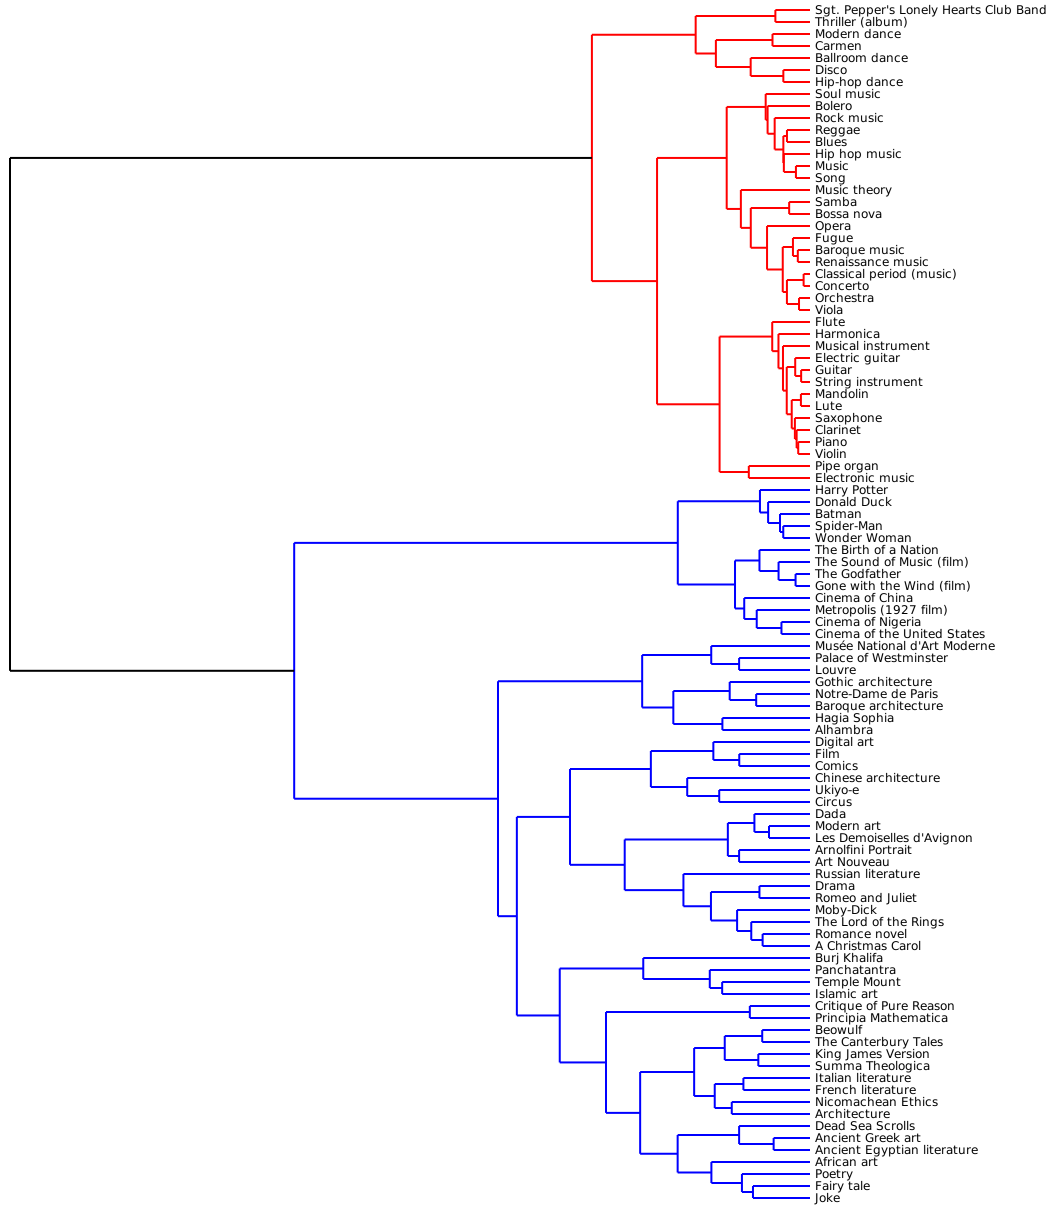

In [79]:
arts_index = np.where(names_labels == 'Arts')[0][0]
arts_articles = np.where(labels == arts_index)[0]
pagerank = PageRank()
weights = {i: 1.0 for i in arts_articles}
scores = pagerank.fit_predict(biadjacency, weights=weights)
top_100_articles = arts_articles[np.argsort(scores[arts_articles])[-100:][::-1]]

dendro = linkage(embedding[top_100_articles], method='ward')
image = visualize_dendrogram(dendro, names=names[top_100_articles], width=800, height=1200, rotate=True)
SVG(image)

In [83]:
# Find index of "painting" among words
painting_word_index = np.where(words == 'painting')[0][0]
painting_embedding = embedding_words[painting_word_index]

# Compute cosine similarities for articles
cosine_similarities_articles = embedding_articles @ painting_embedding / (np.linalg.norm(embedding_articles, axis=1) * np.linalg.norm(painting_embedding) + 1e-10)
top10_articles_idx = np.argsort(cosine_similarities_articles[:10011])[-10:][::-1]
top10_articles = [names[i] for i in top10_articles_idx]

# Compute cosine similarities for words
cosine_similarities_words = embedding_words @ painting_embedding / (np.linalg.norm(embedding_words, axis=1) * np.linalg.norm(painting_embedding) + 1e-10)
top10_words_idx = np.argsort(cosine_similarities_words)[-10:][::-1]
top10_words = [words[i] for i in top10_words_idx]

print("Top 10 closest articles to 'painting':")
for i, article in enumerate(top10_articles, 1):
    print(f"{i}. {article}")

print("\nTop 10 closest words to 'painting':")
for i, word in enumerate(top10_words, 1):
    print(f"{i}. {word}")

Top 10 closest articles to 'painting':
1. Les Demoiselles d'Avignon
2. Hieronymus Bosch
3. Rembrandt
4. Modern art
5. Peter Paul Rubens
6. Gian Lorenzo Bernini
7. Symbolism (arts)
8. Constantin Brâncuși
9. Pieter Bruegel the Elder
10. Johannes Vermeer

Top 10 closest words to 'painting':
1. painting
2. Rembrandt
3. Netherlandish
4. Bruegel
5. Painters
6. Demoiselles
7. Rubens
8. portraiture
9. draughtsman
10. Vermeer


## To do

* Prove that the average cosine similarity between vectors in some set $S$ is equal to the square norm of the centroid of $S$.

$$
S=\{v_1,\ldots,v_n\}
$$
$$
\mu = \frac 1 n \sum_{i=1}^n v_i
$$

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). Comment the results.

Proof:

Let $S = \{v_1, \dots, v_n\}$ with $\forall i \in \{1,\dots,n\}, \lVert v_i \rVert = 1$ and his centroid is $\mu = \frac 1 n \sum_{i=1}^n v_i$. The cosine similarity between vectors in $S$ is
$$
\begin{aligned}
\cos \theta_{ij} & = \frac{v_i \cdot v_j}{\lVert v_i \rVert \lVert v_j\rVert} \\
& = v_i \cdot v_j \text{ because } \lVert v_i \rVert = 1 \thickspace \forall i \in \{1,\dots,n\}
\end{aligned}
$$

The average cosine similarity is defined as the average over all ordered pairs 
$(i,j)$, including pairs where $i=j$. There are $n^2$ such pairs, so the average is:

$$
\frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n}\cos \theta_{ij} = \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} v_i \cdot v_j
$$

and we also have:

$$
\begin{aligned}
\lVert \mu \rVert^2 = \mu \cdot \mu & = \left(\frac{1}{n} \sum_{i=1}^{n} v_i \right) \left(\frac{1}{n} \sum_{j=1}^{n} v_j \right) \\
& = \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} v_i \cdot v_j \\
& = \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n}\cos \theta_{ij}
\end{aligned}
$$
so the average cosine similarity between vectors in $S$ is equal to the square norm of the centroid of $S$

In [99]:
# Find index of "Mammals" in the hierarchical labels
for idx, name in enumerate(names_labels_hierarchy):
    if name.endswith('Mammals'):
        print(f"Index: {idx}, Label: {name}")
        mammals_index = idx

Index: 329, Label: Biological and health sciences|||Organisms|||Animals|||Mammals


In [103]:
spectral = Spectral(20)
embedding_articles = spectral.fit_transform(biadjacency)
print(f"Average cosine similarity (Mammals, bipartite): {np.linalg.norm(np.mean(embedding_articles[labels_hierarchy == mammals_index], axis=0)) ** 2}")

Average cosine similarity (Mammals, bipartite): 0.9448758585495289


In [105]:
print(f"Average cosine similarity (random articles, bipartite): {np.linalg.norm(np.mean(embedding_articles, axis=0)) ** 2}")

Average cosine similarity (random articles, bipartite): 0.006870975506168209


The average cosine similarity for "Mammals" (0.9448758585495289) is much higher than for random articles (0.006870975506168209). This shows that articles in the "Mammals" category are very close to each other in the embedding space, meaning the category is highly topical and coherent, while random articles are almost unrelated.

In [114]:
# Compute average cosine similarity (square norm of centroid) for each of the 11 categories
category_topicality = []
for i, label_name in enumerate(names_labels):
    indices = np.where(labels == i)[0]
    if len(indices) > 0:
        avg_cos_sim = np.linalg.norm(np.mean(embedding_articles[indices], axis=0)) ** 2
        category_topicality.append((label_name, avg_cos_sim, sizes[i]))
    else:
        category_topicality.append((label_name, 0.0, 0))

# Sort categories by topicality (descending)
category_topicality_sorted = sorted(category_topicality, key=lambda x: x[1], reverse=True)

print("Ranking of the 11 categories by topicality (average cosine similarity):")
for rank, (label_name, avg_cos_sim, size) in enumerate(category_topicality_sorted, 1):
    print(f"{rank}. {label_name} (avg cosine similarity: {avg_cos_sim:}, size: {size})")

Ranking of the 11 categories by topicality (average cosine similarity):
1. Mathematics (avg cosine similarity: 0.8385300174774779, size: 300)
2. Geography (avg cosine similarity: 0.5479981912488564, size: 1201)
3. Philosophy and religion (avg cosine similarity: 0.48810415848675637, size: 435)
4. Technology (avg cosine similarity: 0.37556957218276804, size: 746)
5. Arts (avg cosine similarity: 0.28992764199853394, size: 673)
6. Biological and health sciences (avg cosine similarity: 0.2787709661022739, size: 1479)
7. Everyday life (avg cosine similarity: 0.27733534353157996, size: 479)
8. Physical sciences (avg cosine similarity: 0.25013123652168523, size: 1097)
9. History (avg cosine similarity: 0.2442499827178629, size: 680)
10. Society and social sciences (avg cosine similarity: 0.24326601864260747, size: 930)
11. People (avg cosine similarity: 0.1924811120803013, size: 1991)


In [117]:
category_topicality = []
for i, label_name in enumerate(names_labels_hierarchy):
    indices = np.where(labels_hierarchy == i)[0]
    if len(indices) >= 10:
        avg_cos_sim = np.linalg.norm(np.mean(embedding_articles[indices], axis=0)) ** 2
        category_topicality.append((label_name, avg_cos_sim, len(indices)))

# Sort categories by topicality (descending)
category_topicality_sorted = sorted(category_topicality, key=lambda x: x[1], reverse=True)

print("10 most topical hierarchical categories (at least 10 articles):")
for rank, (label_name, avg_cos_sim, size) in enumerate(category_topicality_sorted[:10], 1):
    print(f"{rank}. {label_name} (avg cosine similarity: {avg_cos_sim:}, size: {size})")

print("\n10 less topical hierarchical categories (at least 10 articles):")
for rank, (label_name, avg_cos_sim, size) in enumerate(category_topicality_sorted[-10:], 1):
    print(f"{rank}. {label_name} (avg cosine similarity: {avg_cos_sim:}, size: {size})")

10 most topical hierarchical categories (at least 10 articles):
1. People|||Sports figures|||Team sports|||Association football (avg cosine similarity: 0.9921795558937501, size: 14)
2. Physical sciences|||Astronomy|||Astronomical objects|||Notable stars (avg cosine similarity: 0.9819232648805531, size: 10)
3. Mathematics|||Algebra|||Abstract algebra (avg cosine similarity: 0.9807380600821385, size: 14)
4. Mathematics|||Geometry|||Topology (avg cosine similarity: 0.9803497837559533, size: 10)
5. People|||Musicians and composers|||Western art music|||Composers|||20th century modern (avg cosine similarity: 0.9749668732174116, size: 14)
6. Philosophy and religion|||Eastern religions|||Hinduism (avg cosine similarity: 0.9745047857290126, size: 18)
7. Arts|||Modern visual arts|||Filmmaking|||Films|||Drama film (avg cosine similarity: 0.9699673021877167, size: 10)
8. People|||Musicians and composers|||Popular music|||Rock (avg cosine similarity: 0.9623690360606236, size: 17)
9. Everyday life|